# RNN for time series

In this leasson we will work with a weather timeseries dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany.

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random

## Temperature forecast dataset
This dataset contains measurements of 14 different quantities (e.g. air temperature, atmospheric pressure, humidity, wind direction). The measurements were recorded every 10 minutes over several years. Our data spans the period from 2009 to 2016. We will build a model that takes as input data from the recent past and predicts the air temperature 24 hours in the future.

Here is the dataset
`wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip`

In [10]:
PATH = Path("/data2/yinterian/temperature-forecast/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/temperature-forecast/jena_climate_2009_2016.csv'),
 PosixPath('/data2/yinterian/temperature-forecast/jena_climate_2009_2016.csv.zip')]

In [11]:
! head /data2/yinterian/temperature-forecast/jena_climate_2009_2016.csv

"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50
01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,

I am excited to use ggplot in python. You can install it with `pip install ggplot`.

In [12]:
from ggplot import *

In [13]:
data = pd.read_csv(PATH/"jena_climate_2009_2016.csv")
data["row"] = data.index.values
data.shape

(420551, 16)

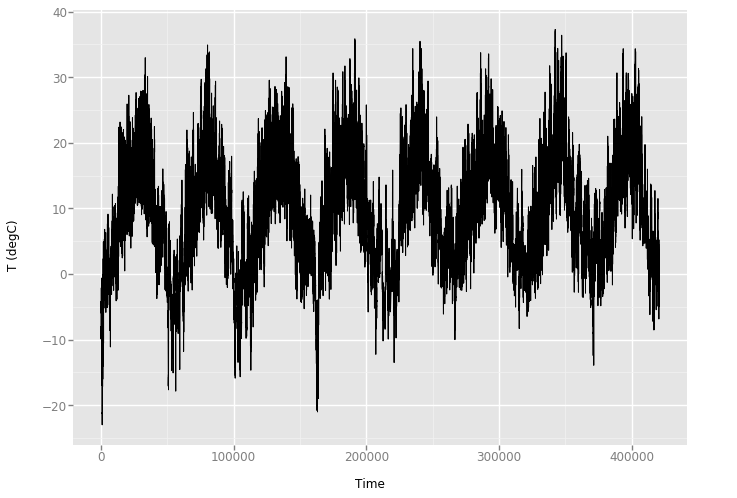

<ggplot: (-9223363303943440440)>

In [14]:
ggplot(data, aes(x = "row", y = "T (degC)")) + geom_line() + xlab("Time")

## Preprocessing data

We will attempt to predict the air temperature 24 hours in the future using 10 days of past temperature. Here is some notation:
* `lookback = 288` — Observations will go back 2 days.
* `steps = 50` — Observations are ar 1 in 50.
* `delay = 72` — Targets will be 12 hours in the future. (144)

Here are the preprocessing steps:
* **Normalizing data**. Each time series in the data is on a different scale (for example, temperature is typically between -20 and +30, but atmospheric pressure, measured in mbar, is around 1,000). We will normalize each time series independently so that they all have a similar scale. 
* **Construct a Dataset**. This dataset object will generate a `x,y` samples ready for the training or testing.

### Normalizing data

In [43]:
from sklearn.preprocessing import StandardScaler

First let's divide the data into training and validation. 

In [74]:
#data.drop("row", axis=1, inplace=True)
max_train_index = 300000
train = data.iloc[:max_train_index].copy()
train.shape

(300000, 16)

In [75]:
valid = data.iloc[max_train_index:].copy()
valid.shape 

(120551, 16)

In [76]:
train.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),row
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,0
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,2
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,3
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3,4


In [77]:
scaler = StandardScaler()
train.iloc[:,1:] = scaler.fit_transform(train.iloc[:,1:])
valid.iloc[:,1:] = scaler.transform(valid.iloc[:,1:]) # just transform for the validation set

In [78]:
#train.describe()
valid.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),row
count,120551.000000,120551.000000,120551.000000,120551.000000,120551.000000,120551.000000,120551.000000,120551.000000,120551.000000,120551.000000,120551.000000,120551.000000,120551.000000,120551.000000,120551.000000
mean,0.237894,0.087607,0.068897,0.114068,0.016261,0.057198,0.077659,0.023090,0.073335,0.073517,-0.029287,-1.023331,-0.750777,0.045034,2.428052
std,1.031784,0.907907,0.914502,0.862977,0.984848,1.025374,0.961219,1.064426,0.961626,0.961212,0.921174,79.985168,55.754259,0.958777,0.401838
min,-5.222641,-2.681950,-2.808220,-2.905986,-3.160118,-1.481793,-1.804605,-0.834527,-1.805672,-1.810786,-2.822126,-6545.700981,-4328.225956,-1.979972,1.732057
25%,-0.357740,-0.623299,-0.634073,-0.586936,-0.617091,-0.703158,-0.718953,-0.638932,-0.721373,-0.721982,-0.698481,-0.792210,-0.810862,-0.432369,2.080054
50%,0.273064,0.023938,-0.001239,0.090587,0.209635,-0.209675,-0.115812,-0.370508,-0.121468,-0.121504,-0.010175,-0.320973,-0.308916,0.304368,2.428052
75%,0.925117,0.732540,0.714289,0.782435,0.826053,0.553335,0.712027,0.255813,0.702003,0.705613,0.648035,0.398971,0.474292,0.678438,2.776050
max,3.241910,3.247384,3.218061,2.209102,1.454558,6.551948,3.358749,8.739242,3.373628,3.362201,3.255671,17.239122,7.544808,2.125680,3.124048


### Construct a Dataset

In [52]:
# the first index we can predict is lookback since we need the past
# the last index we can use is nrow - delay
# we will be sampling one every 6 rows
lookback = 288
steps = 50
delay = 72

In [53]:
n = int((train.shape[0] - lookback - delay)/steps)
n

5992

In [54]:
class TempDataset(Dataset):
    def __init__(self, df, y_index=2, x_max_index=3):
        self.df = df
        self.len = int((df.shape[0] - lookback - delay)/steps)
        self.y_index = y_index
        self.x_max_index = x_max_index
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        min_x_idx = idx*steps
        min_y_idx = idx*steps + lookback
        max_y_idx = min_y_idx + delay
        #"p (mbar)","T (degC)"
        x = self.df.iloc[min_x_idx:min_y_idx, 1:self.x_max_index].values
        y = self.df.iloc[min_y_idx:max_y_idx, self.y_index].values
        return x, y

In [ ]:
train_ds = TempDataset(train)
valid_ds = TempDataset(valid)

In [117]:
batch_size = 1000
n = len(valid_ds)
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=n)

In [118]:
x, y = train_ds[0]

In [119]:
print(x.shape, y.shape)

(288, 2) (72,)


## Baseline model 

## Homemade RNN  

In [58]:
class SimpleEncoder(nn.Module):
    def __init__(self, n_features=2, n_hidden=10):
        super().__init__()
        self.n_hidden = n_hidden
        self.i2i = nn.Linear(n_features, n_hidden)
        self.i2h = nn.Linear(2*n_hidden, n_hidden)
        self.i2o = nn.Linear(2*n_hidden, 1)
    
    def forward(self, x, h):
        x = F.relu(self.i2i(x))
        combined = torch.cat((x, h), 1)
        h = F.tanh(self.i2h(combined))
        x = self.i2o(combined)
        return x, h
    
    def initHidden(self, bash_size):
        return Variable(torch.zeros(bash_size, self.n_hidden))

In [59]:
class SimpleDecoder(nn.Module):
    def __init__(self, n_hidden=10):
        super().__init__()
        self.n_hidden = n_hidden
        self.i2i = nn.Linear(1, n_hidden)
        self.i2h = nn.Linear(2*n_hidden, n_hidden)
        self.i2o = nn.Linear(2*n_hidden, 1)
    
    def forward(self, x, h):
        x = F.relu(self.i2i(x))
        combined = torch.cat((x, h), 1)
        h = F.tanh(self.i2h(combined))
        x = self.i2o(combined)
        return x, h   

### Debuging Model

In [30]:
n_hidden=10
encoder = SimpleEncoder().cuda()
decoder = SimpleDecoder().cuda()

In [31]:
x, y = next(iter(train_dl))
x = Variable(x.float()).cuda()
y = Variable(y.float()).cuda()

In [32]:
bash_size = x.shape[0]
h = Variable(torch.zeros(bash_size, n_hidden)).cuda()

In [33]:
h.size(), x[:,0].size()

(torch.Size([1000, 10]), torch.Size([1000, 2]))

In [34]:
for ei in range(x.shape[1]):
    x_t, h = encoder(x[:,ei], h)

In [35]:
y[:,0].unsqueeze(1).size(), x_t.size()

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [36]:
loss = 0.0
y_t = x_t
for di in range(y.shape[1]):
    y_hat, h = decoder(y_t, h)
    loss += F.l1_loss(y_hat, y[:,di])
    y_t = y[:,di].unsqueeze(1)

### Training Encoder Decoder

In [133]:
encoder = SimpleEncoder().cuda()
decoder = SimpleDecoder().cuda()

In [132]:
def get_optimizers(lr, wd = 0.00001):
    lr = 0.01
    wd = 0.00001
    enc_parameters = filter(lambda p: p.requires_grad, encoder.parameters())
    enc_optim = torch.optim.Adam(enc_parameters, lr=lr, weight_decay=wd)
    de_parameters = filter(lambda p: p.requires_grad, decoder.parameters())
    de_optim = torch.optim.Adam(de_parameters, lr=lr, weight_decay=wd)
    return enc_optim, de_optim

In [122]:
def train(encoder, decoder, enc_optim, de_optim, use_teacher_forcing=True):
    encoder.train()
    decoder.train()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(train_dl):
        batch = x.shape[0]
        h = encoder.initHidden(batch).cuda()
        loss = 0
        x = Variable(x).cuda().float()
        y = Variable(y).cuda().float()
        
        for ei in range(x.shape[1]):
            x_t, h = encoder(x[:,ei], h)
        
        y_t = x_t
        if use_teacher_forcing:
            for di in range(y.shape[1]):
                y_hat, h = decoder(y_t, h)
                loss += F.l1_loss(y_hat, y[:,di])
                y_t = y[:,di].unsqueeze(1)
        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(y.shape[1]):
                y_hat, h = decoder(y_t, h)
                loss += F.l1_loss(y_hat, y[:,di])
                y_t = y_hat
        loss.backward(retain_graph=True)
        enc_optim.step()
        de_optim.step()
        total += batch
        sum_loss += batch*(loss.data[0]/y.shape[1])
        print(i, loss.data[0]/y.shape[1])
    print("loss ", sum_loss/total)
    return sum_loss/total

In [134]:
enc_optim, de_optim = get_optimizers(lr=0.01, wd = 0.00001)
train(encoder, decoder, enc_optim, de_optim, use_teacher_forcing=True)
predict(encoder, decoder, valid_dl)

0 0.80295287238227
1 0.8415026134914823
2 0.820038636525472
3 0.7333167394002279
4 0.7163325415717231
5 0.5526810752020942
loss  0.7447268074051491


0.7524235248565674

In [135]:
train(encoder, decoder, enc_optim, de_optim)
predict(encoder, decoder, valid_dl)

0 0.5615343517727323
1 0.5685317781236436
2 0.5228806601630317
3 0.4448690414428711
4 0.38706578148735893
5 0.2612229718102349
loss  0.45794639536471804


0.7156780958175659

In [138]:
enc_optim, de_optim = get_optimizers(lr=0.001, wd = 0.0001)
train(encoder, decoder, enc_optim, de_optim)
predict(encoder, decoder, valid_dl)

0 0.6255678600735135
1 0.5413233968946669
2 0.45043150583902997
3 0.3474551306830512
4 0.28533053398132324
5 0.16463379065195718
loss  0.40277455737622275


1.3241870403289795

### Old Training 

In [ ]:
def train_one_epoch(model, optimizer):
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(train_dl):      
        batch = x.shape[0]
        x = Variable(x).cuda().float()
        y = Variable(y).cuda().float()
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = model(x).float()
        loss = F.l1_loss(outputs, y)
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += batch * loss.data[0]
    return model, sum_loss/total

In [ ]:
def train_epocs(model, epochs=10, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        model, train_loss = train_one_epoch(model, optimizer)
        print('Epoch [%d/%d], Loss: %.4f' %(i+1, epochs, train_loss))
    test_loss, test_mse_loss = test_metrics(model)
    print('Test MAE Loss: %.4f, MSE Loss %.4f' %(test_loss, test_mse_loss))

In [ ]:
def test_metrics(model):
    total = 0
    sum_loss = 0
    sum_mse_loss = 0
    model.eval()
    for i, (x, y) in enumerate(valid_dl):      
        batch = x.shape[0]
        x = Variable(x).cuda().float()
        y = Variable(y).cuda().float()
        outputs = model(x).float()
        loss = F.l1_loss(outputs, y)
        mse_loss = F.mse_loss(outputs, y)
        sum_loss += batch*loss.data[0]
        sum_mse_loss += batch*mse_loss.data[0]
        total += batch
    return sum_loss/ total, sum_mse_loss/total

In [ ]:
model = Seq2SeqSRNN().cuda()
train_epocs(model, epochs=5, lr=0.01, wd=0.0001)

In [ ]:
train_epocs(model, epochs=5, lr=0.01, wd=0.0)

### Looking at outputs

In [111]:
n = len(valid_ds)

In [112]:

#train_dl = DataLoader(train_ds, batch_size=bs)
valid_dl = DataLoader(valid_ds, batch_size=n)

In [124]:
def predict(encoder, decoder, valid_dl):
    encoder.eval()
    decoder.eval()
    res = []
    x, y = next(iter(valid_dl))
    x = Variable(x).cuda().float()
    y = Variable(y).cuda().float()
    batch = x.shape[0]
    h = encoder.initHidden(batch).cuda()
    for ei in range(x.shape[1]):
        x_t, h = encoder(x[:,ei], h)
    y_t = x_t
    for di in range(y.shape[1]):
        y_hat, h = decoder(y_t, h)
        y_t = y_hat
        res.append(y_hat)
    res = torch.stack(res, 1)
    return F.l1_loss(res.view(res.shape[0], -1), y).data[0]

In [125]:
x, y = next(iter(valid_dl))
predict(encoder, decoder, valid_dl)

0.7584080696105957

In [104]:
y[:,:20]



Columns 0 to 9 
 0.6758  0.6758  0.6758  0.6758  0.6758  0.6758  0.6758  0.6758  0.6793  0.6804
 0.8599  0.8877  0.9016  0.9039  0.9456  1.0023  1.0475  1.0741  1.0984  1.0868

Columns 10 to 19 
 0.6758  0.6828  0.6851  0.6839  0.6804  0.6828  0.6828  0.6828  0.6828  0.6828
 1.1077  1.1401  1.1447  1.1667  1.1772  1.2119  1.2165  1.2628  1.2663  1.2918
[torch.DoubleTensor of size 2x20]

In [105]:
y_hat[:,:20]

Variable containing:

Columns 0 to 9 
 0.6089  0.5627  0.6710  0.8894  1.0616  1.2505  1.4470  1.6158  1.7321  1.8167
 0.7179  0.7047  0.8266  1.0602  1.2471  1.4332  1.6087  1.7274  1.8131  1.8742

Columns 10 to 19 
 1.8769  1.9212  1.9527  1.9749  1.9903  2.0009  2.0082  2.0132  2.0166  2.0189
 1.9192  1.9514  1.9739  1.9897  2.0005  2.0079  2.0130  2.0164  2.0188  2.0204
[torch.cuda.FloatTensor of size 2x20 (GPU 0)]

## Reference